# Baseline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip /content/drive/MyDrive/videos.zip

Archive:  /content/drive/MyDrive/videos.zip
   creating: videos/
  inflating: __MACOSX/._videos       
  inflating: videos/N11GT.mp4        
  inflating: __MACOSX/videos/._N11GT.mp4  
  inflating: videos/7HVU8.mp4        
  inflating: __MACOSX/videos/._7HVU8.mp4  
  inflating: videos/46GP8.mp4        
  inflating: __MACOSX/videos/._46GP8.mp4  
  inflating: videos/VPIYF.mp4        
  inflating: __MACOSX/videos/._VPIYF.mp4  
  inflating: videos/0IH69.mp4        
  inflating: __MACOSX/videos/._0IH69.mp4  
  inflating: videos/KRF68.mp4        
  inflating: __MACOSX/videos/._KRF68.mp4  
  inflating: videos/JSUF4.mp4        
  inflating: __MACOSX/videos/._JSUF4.mp4  
  inflating: videos/S6MPZ.mp4        
  inflating: __MACOSX/videos/._S6MPZ.mp4  
  inflating: videos/MJO7C.mp4        
  inflating: __MACOSX/videos/._MJO7C.mp4  
  inflating: videos/MCQO5.mp4        
  inflating: __MACOSX/videos/._MCQO5.mp4  


In [4]:
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q opencv-python
!pip install -q tqdm pillow numpy
!pip -q install open_clip_torch==2.24.0 opencv-python-headless==4.10.0 gdown tqdm


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.3 MB/s eta 0:00:00
ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.11.41, 4.4.0.40, 4.4.0

In [14]:
import pandas as pd
import pathlib, random, json, math, os, re, sys, time, shutil, itertools, zipfile
from pathlib import Path

def load_charades_sta(path):
    records = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            segment, sentence = line.split('##', maxsplit=1)
            vid, start, end = segment.split()
            records.append({
                'video_id':   vid,
                'start_time': float(start),
                'end_time':   float(end),
                'sentence':   sentence
            })
    return pd.DataFrame(records)

# 载入训练/测试集
df_train = load_charades_sta('/content/charades_sta_test.txt')
df_test  = load_charades_sta('/content/charades_sta_train.txt')

# 快速看一下格式
print(df_train.head())
print(df_test.head())


  video_id  start_time  end_time  \
0    3MSZA        24.3      30.4   
1    3MSZA        24.3      30.4   
2    3MSZA        24.3      30.4   
3    3MSZA        24.3      30.4   
4    AMT7R         4.3      12.5   

                                           sentence  
0                           person turn a light on.  
1    person flipped the light switch near the door.  
2                  person turn the light switch on.  
3  person is playing with the switch for the light.  
4      a person is putting a picture onto the wall.  
  video_id  start_time  end_time                                     sentence
0    AO8RW         0.0       6.9       a person is putting a book on a shelf.
1    Y6R7T        20.8      30.0            person begins to play on a phone.
2    Y6R7T        20.8      30.0         person start playing on their phone.
3    Y6R7T         7.3      17.3              person pouring it into a glass.
4    Y6R7T         7.3      17.3  the person pours some water into th

In [15]:
# ==================== baseline demo for 10 local videos ====================
import os, pathlib, random, math, json, time
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm
import torch
import clip

def load_charades_sta(path):
    records = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            segment, sentence = line.split('##', 1)
            vid, start, end = segment.split()
            records.append({
                'video_id':   vid,
                'start_time': float(start),
                'end_time':   float(end),
                'sentence':   sentence
            })
    return pd.DataFrame(records)

df_test  = load_charades_sta('/content/charades_sta_test.txt')
df_train = load_charades_sta('/content/charades_sta_train.txt')


video_dir = "/content/videos"
video_ids_local = [p.stem for p in pathlib.Path(video_dir).glob("*")]
print(video_ids_local)

eval_df = df_train[df_train.video_id.isin(video_ids_local)].reset_index(drop=True)


# ---------- CLIP ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# ---------- Inference ----------
@torch.no_grad()
def infer_top3_segments(video_path, query,
                        sample_rate=20, extend=4.0, topk=1):

    # --- encode text ---
    text_tokens = clip.tokenize([query], truncate=True).to(device)
    text_feat   = model.encode_text(text_tokens).float()
    text_feat  /= text_feat.norm(dim=-1, keepdim=True)
    text_vec    = text_feat.cpu().numpy().squeeze()

    # --- sample frames & encode image ---
    cap  = cv2.VideoCapture(video_path)
    fps  = cap.get(cv2.CAP_PROP_FPS) or 1.0
    fcnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    ts, feats = [], []
    for idx in range(0, fcnt, sample_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok:
            break
        ts.append(idx / fps)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)
        feat = model.encode_image(pil).float()
        feat /= feat.norm(dim=-1, keepdim=True)
        feats.append(feat.cpu().numpy().squeeze())
    cap.release()
    if not feats:
        return []

    ts     = np.array(ts)            # [T]
    feats  = np.stack(feats, 0)      # [T, D]
    sims   = feats @ text_vec        # [T]

    # --- Find Similarity Peak ---
    peak_i   = int(np.argmax(sims))
    peak_t   = ts[peak_i]
    peak_sim = float(sims[peak_i])

    # ---  extend  ---
    vid_dur = fcnt / fps
    seg_st  = max(0.0, peak_t - extend)
    seg_ed  = min(vid_dur, peak_t + extend)

    return [{"start": seg_st, "end": seg_ed, "score": peak_sim}]

# ---------- IoU & Recall ----------
def iou(a, b):
    inter = max(0, min(a[1], b[1]) - max(a[0], b[0]))
    union = max(a[1], b[1]) - min(a[0], b[0])
    return inter / union if union else 0.0




['N11GT', '0IH69', 'VPIYF', 'S6MPZ', '46GP8', 'MCQO5', '7HVU8', 'MJO7C', 'JSUF4', 'KRF68']


In [18]:
hits = 0
for idx, row in tqdm(eval_df.iterrows(),
                     total=len(eval_df),
                     desc="evaluating"):
    vid, g_st, g_ed, sent = row.video_id, row.start_time, row.end_time, row.sentence
    vpath = os.path.join(video_dir, f"{vid}.mp4")  # or .mkv
    preds = infer_top3_segments(vpath, sent,extend=4.0)
    if not preds:
        print(f"[{vid}] 无预测")
        continue
    top1 = preds[0]
    iou_val = iou((top1["start"], top1["end"]), (g_st, g_ed))
    hits += int(iou_val >= 0.3)
    print(f"#{idx+1:02d} {vid} | IoU={iou_val:.3f} | GT {g_st:.2f}-{g_ed:.2f} | Pred {top1['start']:.2f}-{top1['end']:.2f}")

print(f"\nRecall@1 (IoU≥0.3) on {len(eval_df)} samples: {hits/len(eval_df):.3f}")

evaluating:  10%|█         | 1/10 [00:03<00:32,  3.64s/it]

#01 7HVU8 | IoU=0.400 | GT 0.00-10.00 | Pred 0.00-4.00


evaluating:  20%|██        | 2/10 [00:05<00:22,  2.79s/it]

#02 46GP8 | IoU=0.080 | GT 11.90-21.20 | Pred 20.17-24.88


evaluating:  30%|███       | 3/10 [00:09<00:20,  2.99s/it]

#03 46GP8 | IoU=0.080 | GT 11.90-21.20 | Pred 20.17-24.88


evaluating:  40%|████      | 4/10 [00:13<00:20,  3.44s/it]

#04 KRF68 | IoU=0.404 | GT 0.00-9.90 | Pred 0.00-4.00


evaluating:  50%|█████     | 5/10 [00:17<00:18,  3.67s/it]

#05 KRF68 | IoU=0.300 | GT 10.30-25.00 | Pred 19.76-27.76


evaluating:  60%|██████    | 6/10 [00:22<00:16,  4.24s/it]

#06 KRF68 | IoU=0.404 | GT 0.00-9.90 | Pred 0.00-4.00


evaluating:  70%|███████   | 7/10 [00:26<00:12,  4.19s/it]

#07 KRF68 | IoU=0.000 | GT 4.20-10.90 | Pred 0.00-4.00


evaluating:  80%|████████  | 8/10 [00:29<00:07,  3.74s/it]

#08 MCQO5 | IoU=0.389 | GT 4.20-13.40 | Pred 1.02-9.02


evaluating:  90%|█████████ | 9/10 [00:32<00:03,  3.47s/it]

#09 MCQO5 | IoU=0.046 | GT 29.60-33.00 | Pred 22.10-30.10


evaluating: 100%|██████████| 10/10 [00:36<00:00,  3.64s/it]

#10 MCQO5 | IoU=0.046 | GT 29.60-33.00 | Pred 22.10-30.10

Recall@1 (IoU≥0.3) on 10 samples: 0.500


In [17]:
results = []
for ext in range(1, 11):
    hits = 0
    sum_iou = 0.0
    for _, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc=f"Extend={ext}s"):
        vpath = os.path.join(video_dir, f"{row.video_id}.mp4")
        preds = infer_top3_segments(vpath, row.sentence, extend=ext)
        if preds:
            top1 = preds[0]
            val = iou((top1["start"], top1["end"]), (row.start_time, row.end_time))
            sum_iou += val
            if val >= 0.3:
                hits += 1
    results.append({
        "extend (s)": ext,
        "Recall@1 (IoU≥0.3)": hits / len(eval_df),
        "mIoU": sum_iou / len(eval_df)
    })

df_res = pd.DataFrame(results)
print(df_res)

Extend=10s: 100%|██████████| 10/10 [00:36<00:00,  3.65s/it]

   extend (s)  Recall@1 (IoU≥0.3)      mIoU
0           1                 0.0  0.063195
1           2                 0.0  0.108531
2           3                 0.4  0.150449
3           4                 0.5  0.214817
4           5                 0.5  0.292164
5           6                 0.5  0.363879
6           7                 0.7  0.427747
7           8                 0.8  0.493036
8           9                 0.8  0.550922
9          10                 0.8  0.600805


# CLIP-semantic

In [7]:
import spacy
from scipy.signal import convolve


nlp = spacy.load("en_core_web_sm")

def preprocess_query(query, model, device):

    # --- verb ---
    doc = nlp(query)
    verbs = [tok.lemma_ for tok in doc if tok.pos_ == "VERB"]
    short_q = " ".join(verbs) if verbs else query

    # --- Prompt ---
    templates = [
        "A frame of {} in a video",
        "There is a {}",
        "A video of {}"
    ]
    texts = [tmpl.format(short_q) for tmpl in templates]

    feats = []
    for txt in texts:
        tokens = clip.tokenize([txt], truncate=True).to(device)
        with torch.no_grad():
            f = model.encode_text(tokens).float()
            f /= f.norm(dim=-1, keepdim=True)
        feats.append(f.cpu().numpy().squeeze())

    text_vec = np.stack(feats,0).mean(0)
    text_vec /= np.linalg.norm(text_vec)
    return text_vec


def postprocess_sims(sims,
                     window_sizes=(3,),
                     smooth_k=2,
                     mix_beta=0.2):

    kernel = np.ones(smooth_k)/smooth_k
    sims_sm = convolve(sims, kernel, mode="same")

    sims_mix = mix_beta * sims_sm + (1-mix_beta) * sims

    # 3) multi max-pool
    sims_final = sims_mix.copy()
    for L in window_sizes:
        pooled = np.maximum.reduce([
            np.concatenate([sims_mix[i:], np.zeros(i)]) for i in range(L)
        ])
        sims_final = np.maximum(sims_final, pooled)
    return sims_final

# plot sim-graph

In [19]:
@torch.no_grad()
def infer_segments_hys(video_path, query,
                       sample_rate=6,
                       window_size=5.0,
                       stride=1.0,
                       topk=3,
                       high_ratio=0.6,
                       low_ratio=0.3,
                       min_dur=1.5,
                       device="cuda"):
    """CLIP + 滑窗 + Hysteresis (安全版)"""
    # ----- 文本特征 -----
    text_vec = preprocess_query(query, model, device)

    # ----- 抽帧 -----
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 1.0
    fcnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    ts, feats = [], []
    for idx in range(0, fcnt, sample_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok:
            break
        ts.append(idx / fps)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)
        feat = model.encode_image(pil).float()
        feat /= feat.norm(dim=-1, keepdim=True)
        feats.append(feat.cpu().numpy().squeeze())
    cap.release()
    if not feats:
        return []

    ts    = np.asarray(ts)
    feats = np.stack(feats, 0)
    sims_raw  = feats @ txt_v                            # 帧级相似度 (T,)

    # --- 序列增强 ---
    sims = postprocess_sims(sims_raw,
                            window_sizes=(3,6,9),
                            smooth_k=5)


    # ----- 1) 滑窗候选 -----
    cand, i, T = [], 0, len(ts)
    while i < T:
        st = ts[i]
        j  = np.searchsorted(ts, st + window_size, 'right') - 1
        if j >= i:
            seg_sims = sims[i:j+1]
            score = 0.3 * seg_sims.mean() + 0.7 * seg_sims.max()
            cand.append((i, j, score))
        # 防止 stride=0 产生死循环
        if stride <= 0:
            i += 1
        else:
            i = np.searchsorted(ts, st + stride, 'left')
    if not cand:
        return []

    cand.sort(key=lambda x: x[2], reverse=True)
    cand = cand[:topk]

    # ----- 2) Hysteresis 细化 -----
    out, max_idx = [], len(ts) - 1
    for s_idx, e_idx, sc in cand:
        seg_sims = sims[s_idx:e_idx+1]
        if seg_sims.size == 0:         # ### added
            continue
        seg_sims = np.convolve(seg_sims, np.ones(3)/3, mode="same")
        peak     = int(np.argmax(seg_sims))
        peak_val = seg_sims[peak]
        hi, lo   = peak_val * high_ratio, peak_val * low_ratio

        l = r = peak
        while l-1 >= 0 and seg_sims[l-1] >= hi: l -= 1
        while r+1 < seg_sims.size and seg_sims[r+1] >= hi: r += 1
        while l-1 >= 0 and seg_sims[l-1] >= lo: l -= 1
        while r+1 < seg_sims.size and seg_sims[r+1] >= lo: r += 1

        # --- 索引裁剪，防止越界 --- ### added
        start_idx = int(np.clip(s_idx + l, 0, max_idx))
        end_idx   = int(np.clip(s_idx + r, 0, max_idx))

        start_t = ts[start_idx]
        end_t   = ts[end_idx]

        # --- 最短持续 --- ###
        if end_t - start_t < min_dur:
            pad = (min_dur - (end_t - start_t)) / 2
            start_t = max(0.0, start_t - pad)
            end_t   = min(ts[-1], end_t + pad)

        out.append({"start": start_t,
                    "end"  : end_t,
                    "score": sc})

    if not out:
        return []
    out.sort(key=lambda x: x['score'], reverse=True)
    return out[:topk]


plot:   0%|          | 0/10 [00:00<?, ?it/s]

GT 0.00-10.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

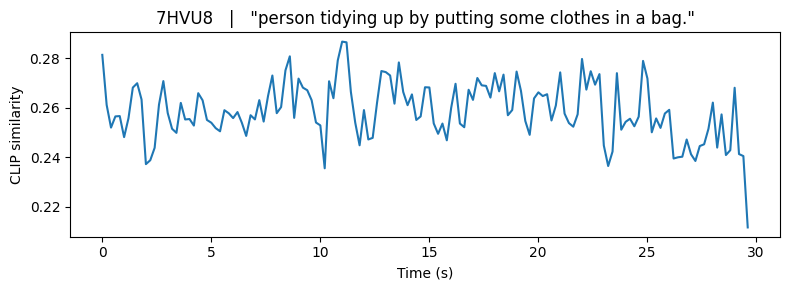

plot:  10%|█         | 1/10 [00:12<01:55, 12.78s/it]

GT 11.90-21.20


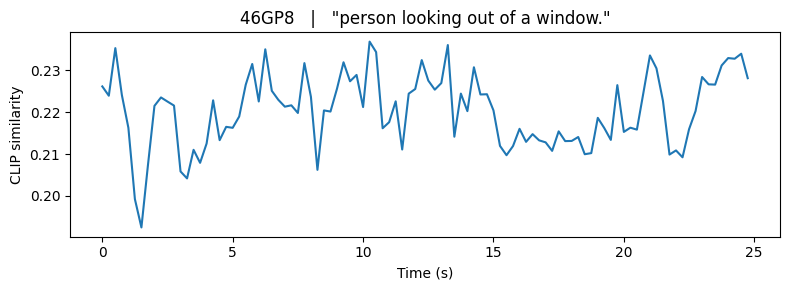

plot:  20%|██        | 2/10 [00:20<01:17,  9.68s/it]

GT 11.90-21.20


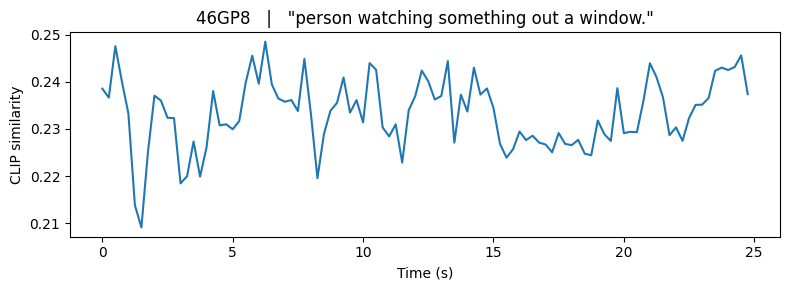

plot:  30%|███       | 3/10 [00:28<01:03,  9.03s/it]

GT 0.00-9.90


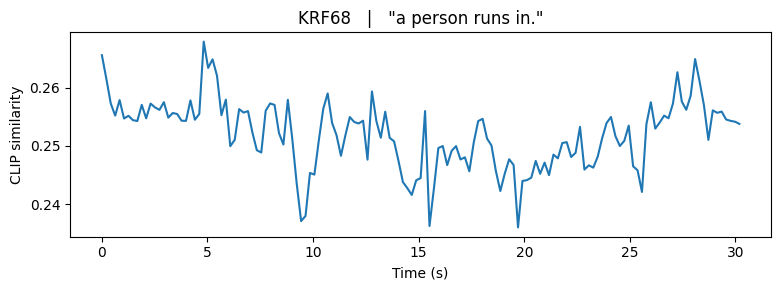

plot:  40%|████      | 4/10 [00:43<01:04, 10.83s/it]


In [22]:

import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image

@torch.no_grad()
def compute_frame_sims(video_path, query, sample_rate=6):
    """return timestamps, similarities（1-D numpy）"""

    tok = clip.tokenize([query], truncate=True).to(device)
    txt = model.encode_text(tok).float()
    txt = txt / txt.norm(dim=-1, keepdim=True)
    txt = txt.cpu().numpy().squeeze()

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 1.0
    fcnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    ts, sims = [], []
    for idx in range(0, fcnt, sample_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok:
            break
        ts.append(idx / fps)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)
        feat = model.encode_image(pil).float()
        feat = feat / feat.norm(dim=-1, keepdim=True)
        sim  = float(feat.cpu().numpy().squeeze() @ txt)
        sims.append(sim)
    cap.release()
    return np.array(ts), np.array(sims)


cnt = 0
for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc="plot"):
    cnt +=1
    if(cnt>4):
      break
    vid, g_st, g_ed, sent = row.video_id, row.start_time, row.end_time, row.sentence
    vpath = os.path.join(video_dir, f"{vid}.mp4")  # or .mkv

    ts, sims = compute_frame_sims(vpath, sent)
    print(f"GT {g_st:.2f}-{g_ed:.2f}" )

    plt.figure(figsize=(8,3))
    plt.plot(ts, sims)
    plt.xlabel("Time (s)")
    plt.ylabel("CLIP similarity")
    plt.title(f"{vid}   |   \"{sent}\"")
    plt.tight_layout()
    if cnt == 1:
      plt.savefig("similarity_curve.pdf", format="pdf", bbox_inches="tight")

      # 如果想同时下载到本地：
      from google.colab import files
      files.download("similarity_curve.pdf")
    plt.show()

plot:   0%|          | 0/10 [00:00<?, ?it/s]

GT 0.00-10.00


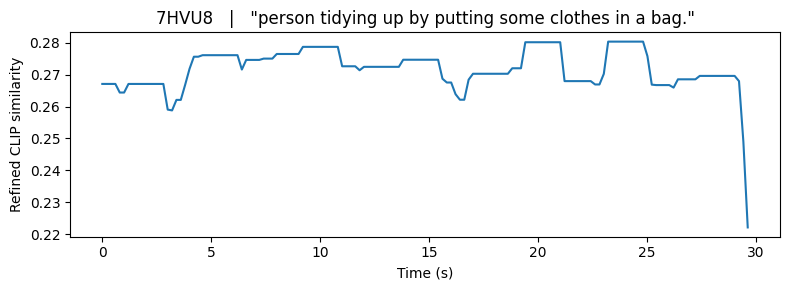

plot:  10%|█         | 1/10 [00:13<02:00, 13.39s/it]

GT 11.90-21.20


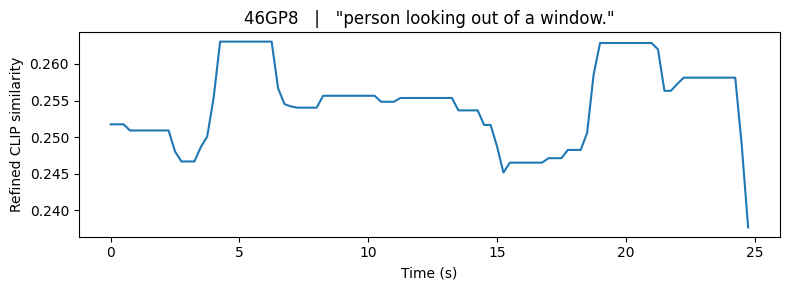

plot:  20%|██        | 2/10 [00:21<01:23, 10.38s/it]

GT 11.90-21.20


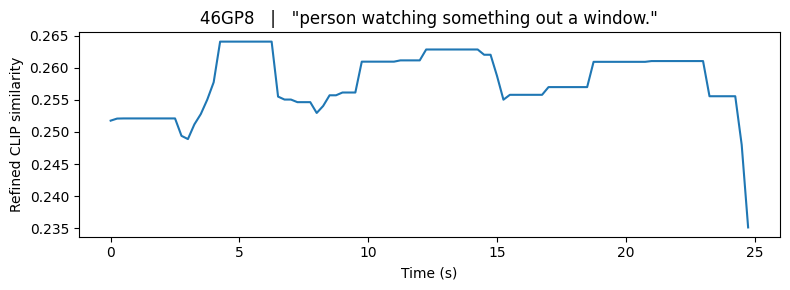

plot:  30%|███       | 3/10 [00:29<01:03,  9.01s/it]

GT 0.00-9.90


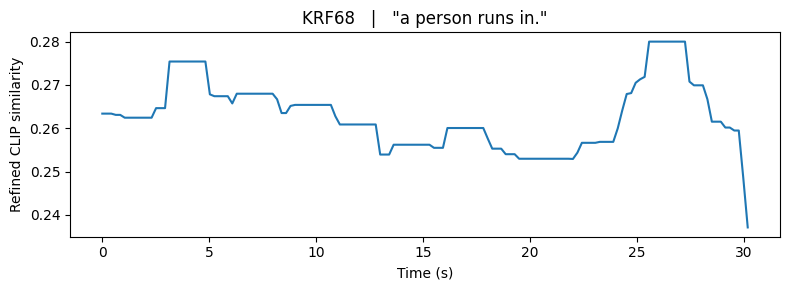

plot:  40%|████      | 4/10 [00:44<01:06, 11.02s/it]


In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image

@torch.no_grad()
def compute_frame_sims(video_path, query, sample_rate=6):
    """返回 timestamps, similarities（均为 1-D numpy）"""
    text_vec = preprocess_query(query, model, device)

    ts, feats = [], []
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 1.0
    fcnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for idx in range(0, fcnt, sample_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok: break
        ts.append(idx/fps)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)
        f = model.encode_image(pil).float()
        f /= f.norm(dim=-1, keepdim=True)
        feats.append(f.cpu().numpy().squeeze())
    cap.release()
    ts    = np.array(ts)
    feats = np.stack(feats,0)
    sims_raw = feats @ text_vec     # (T,)

    # --- 序列增强 ---
    sims = postprocess_sims(sims_raw,
                            window_sizes=(3,6,9),
                            smooth_k=5)
    return np.array(ts), np.array(sims)


# 逐视频绘图
cnt = 0
for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc="plot"):
    cnt +=1
    if(cnt>4):
      break
    vid, g_st, g_ed, sent = row.video_id, row.start_time, row.end_time, row.sentence
    vpath = os.path.join(video_dir, f"{vid}.mp4")  # or .mkv

    ts, sims = compute_frame_sims(vpath, sent)
    print(f"GT {g_st:.2f}-{g_ed:.2f}" )

    plt.figure(figsize=(8,3))
    plt.plot(ts, sims)
    plt.xlabel("Time (s)")
    plt.ylabel("Refined CLIP similarity")
    plt.title(f"{vid}   |   \"{sent}\"")
    plt.tight_layout()
    plt.show()


# Zs复现

In [ ]:
import cv2
import numpy as np
import torch, clip
import spacy
from itertools import product
from sklearn.cluster import KMeans
from PIL import Image


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
nlp = spacy.load("en_core_web_sm")

def preprocess_query(query):

    # 1) verb
    doc = nlp(query)
    verbs = [tok.lemma_ for tok in doc if tok.pos_ == "VERB"]
    short_q = " ".join(verbs) if verbs else query

    # 2) Prompt
    templates = [
        "{} in a video",
        "There is a {}",
        "One frame of {}"
    ]
    feats = []
    for tmpl in templates:
        txt = tmpl.format(short_q)
        tokens = clip.tokenize([txt], truncate=True).to(device)
        with torch.no_grad():
            f = model.encode_text(tokens).float()
            f /= f.norm(dim=-1, keepdim=True)
        feats.append(f.cpu().numpy().squeeze())

    text_vec = np.stack(feats, 0).mean(0)
    text_vec /= np.linalg.norm(text_vec)
    return text_vec

def hysteresis_refine(ts, sims, s_idx, e_idx, high_ratio, low_ratio, min_dur):
    """
    对 [s_idx, e_idx]  sims -> Hysteresis. return (start_t, end_t)
    """
    seg = sims[s_idx:e_idx+1]

    seg_sm = np.convolve(seg, np.ones(3)/3, mode="same")
    peak = int(np.argmax(seg_sm))
    pv = seg_sm[peak]
    hi, lo = pv * high_ratio, pv * low_ratio


    l = r = peak
    while l-1 >= 0 and seg_sm[l-1] >= hi: l -= 1
    while r+1 < seg_sm.size and seg_sm[r+1] >= hi: r += 1

    while l-1 >= 0 and seg_sm[l-1] >= lo: l -= 1
    while r+1 < seg_sm.size and seg_sm[r+1] >= lo: r += 1

    start_idx = s_idx + l
    end_idx   = s_idx + r
    start_t = ts[start_idx]
    end_t   = ts[end_idx]

    if end_t - start_t < min_dur:
        pad = (min_dur - (end_t - start_t)) / 2
        start_t = max(0, start_t - pad)
        end_t   = min(ts[-1], end_t + pad)
    return start_t, end_t

@torch.no_grad()
def infer_zs_qcfr_bupg(video_path, raw_query,
                       sample_rate=6, stride=1.0, window_size=5.0,
                       k_clusters=6, Ln=2, lam=0.5,
                       high_ratio=0.6, low_ratio=0.3, min_dur=1.5):
    """
    Zero-shot Pipeline:
      1) CLIP → feats [T,D], ts [T]
      2)  simple-queries
      3) QC-FR → boundary-aware feats
      4) BU-PG (k-means) → per-simple proposals
      6) Hysteresis  top-3
    """

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 1.0
    fcnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    ts, feats = [], []
    for idx in range(0, fcnt, sample_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok: break
        ts.append(idx / fps)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)
        f = model.encode_image(pil).float()
        f /= f.norm(dim=-1, keepdim=True)
        feats.append(f.cpu().numpy().squeeze())
    cap.release()
    if not feats:
        return []
    ts    = np.array(ts)
    feats = np.stack(feats, 0)   # (T,D)
    T, D  = feats.shape


    doc = nlp(raw_query)
    simple_qs = [
        " ".join([tok.text for tok in span])
        for span in doc.noun_chunks
        if any(t.pos_ == "VERB" for t in span)
    ]
    if not simple_qs:
        simple_qs = [raw_query]

    all_props = []
    for q in simple_qs:
        # 3.1 snippet-query similarity
        txt_v = preprocess_query(q)          # (D,)
        sims  = feats @ txt_v                # (T,)

        # 3.2 QC-FR:
        diffs = (sims[:,None] - sims[None,:])**2   # (T,T)
        ms    = np.argmax(diffs, axis=1)           # (T,)
        W     = np.zeros((T,T), np.float32)
        for i in range(T):
            denom = diffs[i, ms[i]] + 1e-6
            for j in range(max(0, i-Ln), min(T, i+Ln+1)):
                W[i,j] = 1 - diffs[i,j] / denom
        feats_ref = feats + lam * (W @ feats)      # (T,D)

        # 3.3 BU-PG:
        km = KMeans(n_clusters=k_clusters).fit(feats_ref)
        labels = km.labels_
        props = []
        for lbl in range(k_clusters):
            idxs = np.where(labels == lbl)[0]
            if idxs.size == 0: continue
            si, ei = idxs[0], idxs[-1]
            st, ed = ts[si], ts[ei]
            score  = sims[idxs].mean()
            props.append((si, ei, score))
        all_props.append(props)

    # 4) simple-query proposals
    final = []
    for combo in product(*all_props):
        st = min(c[0] for c in combo)
        ed = max(c[1] for c in combo)
        if ed < st: continue
        sc = np.mean([c[2] for c in combo])
        final.append((st, ed, sc))

    # 5)top-3 + Hysteresis
    final = sorted(final, key=lambda x: x[2], reverse=True)[:3]
    out = []
    for si, ei, sc in final:
        start_t, end_t = hysteresis_refine(ts, sims, si, ei,
                                           high_ratio, low_ratio, min_dur)
        out.append({"start": start_t, "end": end_t, "score": sc})
    return out


In [ ]:
hits = 0
for idx, row in tqdm(eval_df.iterrows(),
                     total=len(eval_df),
                     desc="evaluating"):
    vid, g_st, g_ed, sent = row.video_id, row.start_time, row.end_time, row.sentence
    vpath = os.path.join(video_dir, f"{vid}.mp4")  # or .mkv
    preds = infer_zs_qcfr_bupg(vpath, sent)
    if not preds:
        print(f"[{vid}] 无预测")
        continue
    top1 = preds[0]
    iou_val = iou((top1["start"], top1["end"]), (g_st, g_ed))
    hits += int(iou_val >= 0.3)
    print(f"#{idx+1:02d} {vid} | IoU={iou_val:.3f} | GT {g_st:.2f}-{g_ed:.2f} | Pred {top1['start']:.2f}-{top1['end']:.2f} | {sent}")

print(f"\nRecall@1 (IoU≥0.3) on {len(eval_df)} samples: {hits/len(eval_df):.3f}")

evaluating:  10%|█         | 1/10 [00:14<02:09, 14.34s/it]

#01 7HVU8 | IoU=0.440 | GT 0.00-10.00 | Pred 5.21-9.61 | person tidying up by putting some clothes in a bag.


evaluating:  20%|██        | 2/10 [00:22<01:24, 10.58s/it]

#02 46GP8 | IoU=0.744 | GT 11.90-21.20 | Pred 10.50-23.00 | person looking out of a window.


evaluating:  30%|███       | 3/10 [00:31<01:08,  9.83s/it]

#03 46GP8 | IoU=0.018 | GT 11.90-21.20 | Pred 21.00-22.75 | person watching something out a window.


evaluating:  40%|████      | 4/10 [00:47<01:13, 12.20s/it]

#04 KRF68 | IoU=0.199 | GT 0.00-9.90 | Pred 4.40-27.67 | a person runs in.


evaluating:  50%|█████     | 5/10 [01:02<01:07, 13.53s/it]

#05 KRF68 | IoU=0.399 | GT 10.30-25.00 | Pred 12.16-18.03 | the person starts dressing.


evaluating:  60%|██████    | 6/10 [01:25<01:05, 16.49s/it]

#06 KRF68 | IoU=0.199 | GT 0.00-9.90 | Pred 4.40-27.67 | a person runs into their laundry room.


evaluating:  70%|███████   | 7/10 [01:42<00:50, 16.76s/it]

#07 KRF68 | IoU=0.277 | GT 4.20-10.90 | Pred 4.40-27.67 | person close the door.


evaluating:  80%|████████  | 8/10 [01:53<00:30, 15.05s/it]

#08 MCQO5 | IoU=0.000 | GT 4.20-13.40 | Pred 0.00-1.81 | a person is undressing in the closet.


evaluating:  90%|█████████ | 9/10 [02:05<00:13, 13.92s/it]

#09 MCQO5 | IoU=0.000 | GT 29.60-33.00 | Pred 25.29-26.80 | person drink a glass of water.


evaluating: 100%|██████████| 10/10 [02:16<00:00, 13.65s/it]

#10 MCQO5 | IoU=0.000 | GT 29.60-33.00 | Pred 25.29-26.80 | person drink from a bottle of water in a bedroom.

Recall@1 (IoU≥0.3) on 10 samples: 0.300


# 融合特征

In [ ]:
# ======== Cell 2: Full Zero‐Shot Pipeline with CLIP + DINO ========
import os
import cv2
import torch
import clip
import timm
import spacy
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

# ---------- Config ----------
VIDEO_DIR   = "/content/videos"
ANN_PATH    = "/content/charades_sta_test.txt"
SAMPLE_RATE = 6
WINDOW_SIZE = 5.0
STRIDE      = 1.0
TOPK        = 3
HIGH_RATIO  = 0.6
LOW_RATIO   = 0.3
MIN_DUR     = 1.5

# ---------- Load Models ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
# CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
# DINO
dino = timm.create_model('vit_small_patch16_224_dino', pretrained=True).to(device).eval()
# spaCy
nlp = spacy.load("en_core_web_sm")

# ---------- Helpers ----------
def extract_frame_feats(img: Image.Image):
    """featre:CLIP + DINO"""
    x = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        # CLIP
        cf = clip_model.encode_image(x).float()
        cf /= cf.norm(dim=-1, keepdim=True)
        # DINO: take cls token
        feat = dino.forward_features(x)       # [1,197,D]
        df = feat[:,0]                        # [1,D]
        df /= df.norm(dim=-1, keepdim=True)
    return cf.cpu().numpy().squeeze(), df.cpu().numpy().squeeze()

def encode_text(query: str):
    """CLIP text"""
    tokens = clip.tokenize([query], truncate=True).to(device)
    with torch.no_grad():
        tf = clip_model.encode_text(tokens).float()
        tf /= tf.norm(dim=-1, keepdim=True)
    return tf.cpu().numpy().squeeze()

def hysteresis(ts, sims, si, ei):
    """Hysteresis:(start_t, end_t)"""
    seg = sims[si:ei+1]
    sm = np.convolve(seg, np.ones(3)/3, mode="same")
    peak = sm.argmax(); pv = sm[peak]
    hi, lo = pv*HIGH_RATIO, pv*LOW_RATIO

    l=r=peak
    while l>0     and sm[l-1]>=hi: l-=1
    while r<sm.size-1 and sm[r+1]>=hi: r+=1
    while l>0     and sm[l-1]>=lo: l-=1
    while r<sm.size-1 and sm[r+1]>=lo: r+=1

    st = max(0, si+l)
    ed = min(len(ts)-1, si+r)
    t0, t1 = ts[st], ts[ed]
    if t1-t0 < MIN_DUR:
        pad=(MIN_DUR-(t1-t0))/2
        t0,t1 = max(0,t0-pad), min(ts[-1],t1+pad)
    return t0, t1
import cv2
import numpy as np
from PIL import Image

def compute_flow_mags(video_path, sample_rate=6):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 1.0
    frame_idxs = list(range(0, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), sample_rate))
    mags, ts = [], []
    prev = None
    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frm = cap.read()
        if not ok: break
        gray = cv2.cvtColor(frm, cv2.COLOR_BGR2GRAY)
        if prev is not None:
            flow = cv2.calcOpticalFlowFarneback(prev, gray,
                                                None,
                                                pyr_scale=0.5, levels=3,
                                                winsize=15, iterations=3,
                                                poly_n=5, poly_sigma=1.2,
                                                flags=0)
            mag, _ = cv2.cartToPolar(flow[...,0], flow[...,1])
            mags.append(mag.mean())
            ts.append(idx / fps)
        prev = gray
    cap.release()
    mags = np.array(mags)

    if mags.max()>0:
        mags = mags / mags.max()
    return np.array(ts), mags

@torch.no_grad()
def infer_with_flow(video_path, query,
                    sample_rate=6, window_size=5.0, stride=1.0,
                    alpha=0.7, topk=3, **hys_kwargs):

    tv = encode_text(query)   # 512-d CLIP text


    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 1.0
    cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    clip_sims, ts_img = [], []
    for idx in range(0, cnt, sample_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frm = cap.read()
        if not ok: break
        ts_img.append(idx / fps)
        img = Image.fromarray(cv2.cvtColor(frm, cv2.COLOR_BGR2RGB))
        cf = clip_model.encode_image(clip_preprocess(img).unsqueeze(0).to(device))
        cf = cf.float() / cf.norm(dim=-1,keepdim=True)
        clip_sims.append(float((cf.cpu().numpy().squeeze() @ tv)))
    cap.release()
    clip_sims = np.array(clip_sims)
    ts_img    = np.array(ts_img)

    ts_flow, flow_mags = compute_flow_mags(video_path, sample_rate)

    flow_interp = np.interp(ts_img, ts_flow, flow_mags, left=0, right=0)
    sims = alpha * clip_sims + (1-alpha) * flow_interp

    cand, i = [], 0
    T = len(ts_img)
    while i < T:
        st = ts_img[i]
        j  = np.searchsorted(ts_img, st + window_size, 'right') - 1
        if j >= i:
            seg = sims[i:j+1]
            score = 0.3*seg.mean() + 0.7*seg.max()
            cand.append((i,j,score))
        i = np.searchsorted(ts_img, st + stride, 'left') or (i+1)
    cand = sorted(cand, key=lambda x:x[2], reverse=True)[:topk]

    out = []
    for si, ei, sc in cand:
        t0,t1 = hysteresis(ts_img, sims, si, ei, **hys_kwargs)
        out.append({"start":t0, "end":t1, "score":sc})
    return out


def infer(video_path, query):

    tv  = encode_text(query)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 1.0
    cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    ts, feats = [], []
    for idx in range(0, cnt, SAMPLE_RATE):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frm = cap.read()
        if not ok: break
        ts.append(idx/fps)
        img = Image.fromarray(cv2.cvtColor(frm, cv2.COLOR_BGR2RGB))
        cf, df = extract_frame_feats(img)
        clip_sim = float(cf @ tv)
        df_padded = np.concatenate([df, np.zeros(cf.shape[0] - df.shape[0])])
        dino_sim  = float(df_padded @ tv)
        #dino_sim = float(df @ tv)
        sim_fuse = 0.6 * clip_sim + 0.4 * dino_sim
        feats.append(sim_fuse)
    cap.release()
    if not feats: return []
    ts = np.array(ts)
    feats = np.stack(feats)


    sims = feats


    cands=[]
    i=0; T=len(ts)
    while i<T:
        st=ts[i]
        j = np.searchsorted(ts, st+WINDOW_SIZE, 'right')-1
        if j>=i:
            seg=sims[i:j+1]
            score=0.3*seg.mean()+0.7*seg.max()
            cands.append((i,j,score))
        i = np.searchsorted(ts, st+STRIDE, 'left') or (i+1)
    if not cands: return []


    cands=sorted(cands,key=lambda x:x[2],reverse=True)[:TOPK]
    out=[]
    for si,ei,sc in cands:
        t0,t1 = hysteresis(ts,sims,si,ei)
        out.append({'start':t0,'end':t1,'score':sc})
    return out


In [ ]:
hits = 0
for idx, row in tqdm(eval_df.iterrows(),
                     total=len(eval_df),
                     desc="evaluating"):
    vid, g_st, g_ed, sent = row.video_id, row.start_time, row.end_time, row.sentence
    vpath = os.path.join(video_dir, f"{vid}.mp4")  # or .mkv
    preds = infer_with_flow(vpath, sent)
    if not preds:
        print(f"[{vid}] 无预测")
        continue
    top1 = preds[0]
    iou_val = iou((top1["start"], top1["end"]), (g_st, g_ed))
    hits += int(iou_val >= 0.3)
    print(f"#{idx+1:02d} {vid} | IoU={iou_val:.3f} | GT {g_st:.2f}-{g_ed:.2f} | Pred {top1['start']:.2f}-{top1['end']:.2f} | {sent}")

print(f"\nRecall@1 (IoU≥0.3) on {len(eval_df)} samples: {hits/len(eval_df):.3f}")

evaluating:  10%|█         | 1/10 [00:33<05:03, 33.76s/it]

#01 7HVU8 | IoU=0.155 | GT 0.00-10.00 | Pred 8.01-12.81 | person tidying up by putting some clothes in a bag.


evaluating:  20%|██        | 2/10 [00:54<03:30, 26.32s/it]

#02 46GP8 | IoU=0.007 | GT 11.90-21.20 | Pred 7.00-12.00 | person looking out of a window.


evaluating:  30%|███       | 3/10 [01:14<02:42, 23.25s/it]

#03 46GP8 | IoU=0.007 | GT 11.90-21.20 | Pred 7.00-12.00 | person watching something out a window.


evaluating:  40%|████      | 4/10 [01:54<02:59, 29.84s/it]

#04 KRF68 | IoU=0.000 | GT 0.00-9.90 | Pred 26.20-29.98 | a person runs in.


evaluating:  50%|█████     | 5/10 [02:34<02:47, 33.58s/it]

#05 KRF68 | IoU=0.000 | GT 10.30-25.00 | Pred 26.20-29.98 | the person starts dressing.


evaluating:  60%|██████    | 6/10 [03:14<02:22, 35.73s/it]

#06 KRF68 | IoU=0.000 | GT 0.00-9.90 | Pred 26.20-30.19 | a person runs into their laundry room.


evaluating:  70%|███████   | 7/10 [03:54<01:51, 37.09s/it]

#07 KRF68 | IoU=0.000 | GT 4.20-10.90 | Pred 26.20-30.19 | person close the door.


evaluating:  80%|████████  | 8/10 [04:20<01:07, 33.61s/it]

#08 MCQO5 | IoU=0.275 | GT 4.20-13.40 | Pred 2.41-7.23 | a person is undressing in the closet.


evaluating:  90%|█████████ | 9/10 [04:46<00:31, 31.20s/it]

#09 MCQO5 | IoU=0.000 | GT 29.60-33.00 | Pred 2.41-7.23 | person drink a glass of water.


evaluating: 100%|██████████| 10/10 [05:11<00:00, 31.17s/it]

#10 MCQO5 | IoU=0.000 | GT 29.60-33.00 | Pred 2.41-7.23 | person drink from a bottle of water in a bedroom.

Recall@1 (IoU≥0.3) on 10 samples: 0.000
